In [5]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import missingno as msno
import numpy as np
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA


sns.set(rc={'figure.figsize':(8, 4)})

### Data loading and cleanup

In [40]:
df = pd.read_csv("encoded_cleaned_no_strains.csv")
df.Date = pd.to_datetime(df.Date)
df = df.set_index('Date')
#df = df.drop('Daily Recovered', 1)
df = df.dropna()
#df['housing_factor'] = df['housing_factor'].astype('category')
#df['site_factor'] = df['site_factor'].astype('category')
df.drop(['Staff Reported Positive Tests', 'X', 'Y', 'Average Presumptive Cases', 'site_factor'], axis=1, inplace=True)

def label_strain(row):
    s = ''
    if row['B.1.1.7 (Alpha)'] == 1:
        s += 'Alpha, '
    if row['B.1.351 (Beta)'] == 1:
        s += 'Beta, '
    if row['P.1 (Gamma)'] == 1:
        s += 'Gamma, '
    if row['B.1.617 (Delta)'] == 1:
        s += 'Delta, '
    if row['B.1.427/B.1.429 (Epsilon)'] == 1:
        s += 'Epsilon, '
    if row['N679K/Q954H (Omicron)'] == 1:
        s += 'Omicron, '
    if not s:
        return None
    else:
        return s

### Plotting

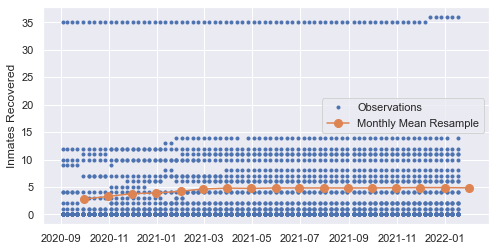

In [3]:
var = 'Confirmed Inmate Deaths'

df_weekly_mean = df[var].resample('M').mean()

fig, ax = plt.subplots()
ax.plot(df[var], marker='.', linestyle='None', linewidth=0.5, label='Observations')
ax.plot(df_weekly_mean, marker='o', markersize=8, linestyle='-', label='Monthly Mean Resample')
ax.set_ylabel('Inmates Recovered')
ax.legend()

In [ ]:
fig.savefig('figures/inmates-recovered.png', bbox_inches='tight')

# Unsupervised ML: Clustering

In [41]:
from sklearn.preprocessing import StandardScaler
columns_to_scale  = ['# of Currently Positive Staff', ' Staff Deaths', 'Staff Recovered',
                    'Isolation Inmates', 'Positive Inmates', 'Confirmed Inmate Deaths', 
                     'Pending Results', 'Recovered Inmates', 'N1', 'N2']

scaler = StandardScaler()
#data  = scaler.fit_transform(df) 

# Scale and Encode Separate Columns
encoded_columns = df[['housing_factor']]
scaled_columns  = scaler.fit_transform(df[columns_to_scale]) 
data = np.concatenate([scaled_columns, encoded_columns], axis=1)
columns_to_scale.append('housing_factor')
data = pd.DataFrame(data = data, columns = df.columns)
#data.to_csv('data_scaled.csv', index=False)

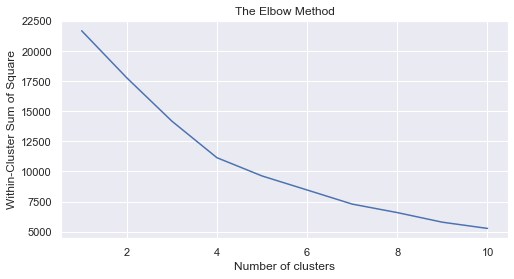

In [44]:
wcss = []
for i in range(1,11):
    kmeans = KMeans(n_clusters=i,init='k-means++', random_state=42)
    kmeans.fit(data)
    wcss.append(kmeans.inertia_)
plt.plot(range(1,11),wcss)
plt.title('The Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('Within-Cluster Sum of Square')
plt.savefig('figures/kmeans-wcss.png', bbox_inches='tight')

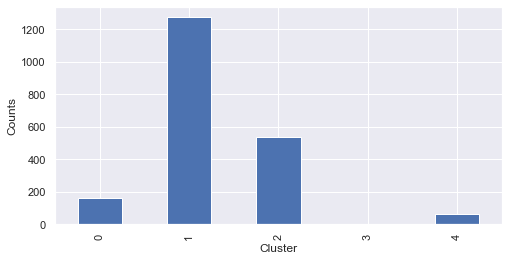

In [50]:
kmeans = KMeans(n_clusters=5,init='k-means++', random_state=40) 
data["Cluster"] = kmeans.fit_predict(data)
bins=np.arange(0,5)
data.Cluster.value_counts().loc[[0,1,2,3,4]].plot.bar()
plt.xlabel('Cluster')
plt.ylabel('Counts')
plt.savefig('figures/kmeans-cluster.png', bbox_inches='tight')

In [51]:
#PCA with three principal components
pca_3d = PCA(n_components=3)
PCs = pd.DataFrame(pca_3d.fit_transform(data.drop(["Cluster"], axis=1)))

PCs.columns = ["PC1", "PC2", "PC3"]

data = pd.concat([data,PCs], axis=1, join='inner')
#cluster0 = data[data["Cluster"] == 0]
#cluster1 = plotData[plotData["Cluster"] == 1]
#cluster2 = plotData[plotData["Cluster"] == 2]
#cluster3 = plotData[plotData["Cluster"] == 3]

In [52]:
print('Explained variation per principal component: {}'.format(sum(pca_3d.explained_variance_ratio_)))

Explained variation per principal component: 0.6420934305809023


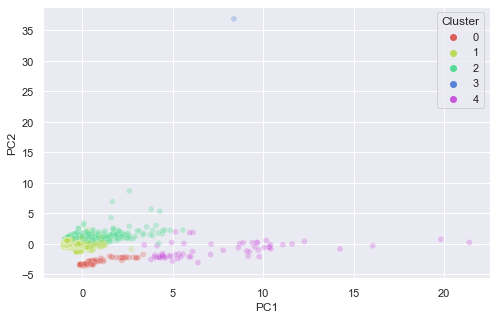

In [59]:
plt.figure(figsize=(8,5))
sns.scatterplot(
    x='PC1', y='PC2',
    hue="Cluster",
    palette=sns.color_palette("hls", 5),
    data=data,
    legend="full",
    alpha=0.3
)
plt.savefig('figures/kmeans-plot1.png', bbox_inches='tight')